# FIT5202 Data processing for Big data

# Assignment 1: Analysing Trip Data 

## Table of Contents

* [1. Working with RDD](#task1)
    * [1.1 Data Preparation and Loading](#task11)
    * [1.2 Data Partitioning in RDD](#task12)
    * [1.3 Query/Analysis](#task13)
* [2. Working with DataFrames](#task2)
    * [2.1 Data Preparation and Loading](#task21)
    * [2.2 Query/Analysis](#task22)
    * [2.3 Trip Analysis](#task23)
* [3. RDDs vs DataFrame vs Spark SQL](#task3)

By Jiawei Ren;

Enviroment: Python 3+ and PySpark 3.0.0 

Dataset link: https://www.kaggle.com/datasets/ivanchvez/99littleorange

## Part1. Working with RDD  <a class="anchor" id="task1"></a>

### 1.1 Data Preparation and Loading <a class="anchor" id="task11"></a>

In [1]:
# 1
# Import SparkConf, sparkcontext, sparksession class into program
from pyspark import SparkConf
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
import pandas as pd
# as many working processors as logical cores on your machine
master = "local[*]"
app_name = "ass1"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# create a SparkContext object using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')
 

In [2]:
# 2 Import all the “Trip” csv files into a single RDD. 
trip_rdd = sc.textFile('data//trip.csv')
# 3. Import all the “Passenger” csv files into a single RDD. 
passenger_rdd = sc.textFile('data//passenger.csv')
# 4. For both Trip and Passenger, remove the header rows and display the total count
# and first 5 records. 
passenger_header = passenger_rdd.first()
trip_header = trip_rdd.first()
passenger_rdd = passenger_rdd.filter(lambda row: row != passenger_header) 
trip_rdd = trip_rdd.filter(lambda row: row != trip_header) 
print( 'first 5 passenger_rdd records: ', *passenger_rdd.take(5),'the total count :', passenger_rdd.count(),sep='\n')
print( 'first 5 trip_rdd records: ', *trip_rdd.take(5),'the total count :', trip_rdd.count(),sep='\n')

first 5 passenger_rdd records: 
00000fab,5/11/2019 8:23:54 PM
0000149d,12/24/2018 9:21:33 PM
00002b66,9/20/2018 9:08:24 PM
00002bc7,7/28/2019 11:27:56 AM
0000332e,2/21/2019 11:34:24 PM
the total count :
1235782
first 5 trip_rdd records: 
a84c0db2,cb64172e,2ea4359d,43006,9/8/2019 10:01:28 PM,9/8/2019 10:15:54 PM,0.3,1.92,4.36
a84c2d10,3034e6fe,e1bd0c8d,43006,7/1/2019 8:56:28 PM,7/1/2019 9:22:09 PM,0,9.36,6.91
a84c3e75,93fb6802,75e6d450,43050,8/20/2019 9:30:46 PM,8/20/2019 9:46:48 PM,0,4.39,3.48
a84c3f6f,25fc9273,5ba48e89,43020,9/8/2019 2:42:41 AM,9/8/2019 2:59:56 AM,0,2.04,1.54
a84c5ce2,484c4d0c,fdb2ef59,43006,6/10/2019 9:29:18 AM,6/10/2019 9:55:36 AM,0,7.37,5.83
the total count :
2318357


### 1.2 Data Partitioning in RDD <a class="anchor" id="task12"></a>

In [3]:
#1. How many partitions do the above RDDs have? How is the data in these RDDs
#   partitioned by default, when we do not explicitly specify any partitioning strategy? 

trip_rdd_numPartitions = trip_rdd.getNumPartitions()
passenger_rdd_numPartitions = passenger_rdd.getNumPartitions()
print('trip_rdd has',trip_rdd_numPartitions, ' partitions')
print('\npassenger_rdd has',passenger_rdd_numPartitions, ' partitions')
print('\nBy defualt, spark uses random equal partitioning to partition the data')

trip_rdd has 6  partitions

passenger_rdd has 2  partitions

By defualt, spark uses random equal partitioning to partition the data


In [4]:
#2a.  
# if else function, if it is in 2019 then 'In 2019' else 'Not In 2019' as the key 
passenger_rdd_2 = passenger_rdd.map(lambda x: x.split(',')).\
    map(lambda x: ['In 2019' if (pd.to_datetime(x[1]) < pd.to_datetime('2020') and pd.to_datetime('2019') < pd.to_datetime(x[1]))
                   else 'Not In 2019', x])
#print the first 5 records
passenger_rdd_2.take(5)

[['In 2019', ['00000fab', '5/11/2019 8:23:54 PM']],
 ['Not In 2019', ['0000149d', '12/24/2018 9:21:33 PM']],
 ['Not In 2019', ['00002b66', '9/20/2018 9:08:24 PM']],
 ['In 2019', ['00002bc7', '7/28/2019 11:27:56 AM']],
 ['In 2019', ['0000332e', '2/21/2019 11:34:24 PM']]]

In [5]:
# function for partition 
#check the key, if it is 'In 2019' then partition 0 otherwise partition 1
def by_year_function(key):
    if key == 'In 2019':
        return 1
    else:
        return 2

In [6]:
#2b keep all the data related to 2019 in one partition and keep
#   the other year’s data in another partition.
# so we only need two partitions
no_of_partitions = 2

range_partitioned_rdd = passenger_rdd_2.partitionBy(no_of_partitions, by_year_function)
#range_partitioned_rdd.glom().collect()

## 1.3 Query/Analysis <a class="anchor" id="task13"></a>

In [7]:
#1.
# split dataset by ',' and filter empty string '' first then filter 0 values
trip_rdd_2 = trip_rdd.map(lambda x: x.split(',')).\
    filter(lambda x: x[6] != '' and x[7] !='').filter(lambda x: (float(x[6]) and float(x[7])) != 0)

In [8]:
print(' count\n',  f'before: {trip_rdd.count()}\n', f'after: {trip_rdd_2.count()}')

 count
 before: 2318357
 after: 303227


In [9]:
#2.Calculate the average surge rate for each city. (Hint: you can use 'city_id' directly)  
# I will use filtered data to calculate average value
trip_rdd_3  = trip_rdd_2.map(lambda x: (x[3],float(x[6]))).groupByKey().\
    mapValues(lambda x: sum(x) / len(x))

In [10]:
trip_rdd_3.collect()

[('43020', 0.35608648040726326),
 ('43116', 0.3373307210031182),
 ('43050', 0.3573732106339663),
 ('43278', 0.3154431028591009),
 ('43006', 0.3478644482858144),
 ('43179', 0.3401958209850762)]

In [11]:
#3. Find the driver id who has the max and min trip distance. Also, print out all other trips they made.

# filter the negative value of trip distance
trip_rdd_4 = trip_rdd_2.filter(lambda x: float(x[7]) > 0 )

#find driver id with max trip distance
max_driver_id = trip_rdd_4.max(lambda x: float(x[7]))
max_driver_id = max_driver_id[1]
#find driver id with mini trip distance
min_driver_id = trip_rdd_4.min(lambda x: float(x[7]))  
min_driver_id = min_driver_id[1]

In [12]:
print(f'driver id with max trip distance: {max_driver_id}', f'\ndriver id with mini trip distance: {min_driver_id}')

driver id with max trip distance: 6f99c4f8 
driver id with mini trip distance: 8f9f5829


In [13]:
#print out all other trips they made.

max_distance_driver_trips = trip_rdd_4.filter(lambda x: x[1]== max_driver_id)
mini_distance_driver_trips = trip_rdd_4.filter(lambda x: x[1]== min_driver_id)


In [14]:
print('max_distance_driver_trips: \n', *max_distance_driver_trips.collect(),sep='\n')
print('\nmini_distance_driver_trips \n', *mini_distance_driver_trips.collect(),sep='\n')

max_distance_driver_trips: 

['848b2841', '6f99c4f8', 'a254f292', '43179', '7/23/2019 5:57:21 AM', '7/23/2019 9:09:03 AM', '-0.15', '150.94', '234.75']
['228612d6', '6f99c4f8', '09188262', '43179', '6/16/2019 9:19:48 AM', '6/16/2019 9:29:09 AM', '-0.1', '2.54', '5.39']
['27b31513', '6f99c4f8', '995cba39', '43179', '9/11/2019 2:01:39 AM', '9/11/2019 2:21:58 AM', '-0.25', '6.29', '4.29']
['3d1a803a', '6f99c4f8', 'f507ac82', '43179', '8/29/2019 7:27:44 AM', '8/29/2019 7:39:55 AM', '-0.1', '3.68', '8.92']
['91252952', '6f99c4f8', 'f1950dcd', '43179', '7/18/2019 11:35:48 AM', '7/18/2019 11:55:30 AM', '-0.2', '8.02', '8.59']
['b5ac17d7', '6f99c4f8', '2eeed548', '43179', '5/26/2019 10:36:29 AM', '5/26/2019 10:59:06 AM', '-0.1', '3.93', '12.64']

mini_distance_driver_trips 

['ae8f21d4', '8f9f5829', '38404301', '43179', '5/27/2019 6:38:24 AM', '5/27/2019 6:48:19 AM', '0.6', '0.01', '2.64']
['ed8bab5a', '8f9f5829', '19872215', '43179', '6/17/2019 5:46:21 AM', '6/17/2019 6:20:39 AM', '1.5', '3.9

## Part2. Working with DataFrames <a class="anchor" id="task2"></a>

### 2.1 Data Preparation and Loading <a class="anchor" id="task21"></a>

In [15]:
#1. Load all trips, passenger, and city data into three separate dataframes

df_passenger = spark.read.csv("data//passenger.csv",inferSchema=True ,header=True)
df_trip = spark.read.csv("data//trip.csv",header=True,inferSchema=True)
df_city = spark.read.csv("data//city.csv",header=True,inferSchema=True)

In [16]:
#2. Display the schema of the final three dataframes.
print('df_passenger schema:')
df_passenger.printSchema()
print('df_trip schema: ')
df_trip.printSchema()
print('df_city schema: ')
df_city.printSchema()

df_passenger schema:
root
 |-- id: string (nullable = true)
 |-- first_call_time: string (nullable = true)

df_trip schema: 
root
 |-- id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- call_time: string (nullable = true)
 |-- finish_time: string (nullable = true)
 |-- surge_rate: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_fare: double (nullable = true)

df_city schema: 
root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)



### 2.2 Query/Analysis <a class="anchor" id="task22"></a>

In [17]:
#1. Rename ‘id’ in city DF into ‘city_id’.
df_city = df_city.withColumnRenamed('id','city_id')
df_city.show(5)

+-------+------------+
|city_id|        name|
+-------+------------+
|  42868|      Mordor|
|  42948|      Erebor|
|  43006|Minas Tirith|
|  43020|    Isengard|
|  43050|      Gondor|
+-------+------------+
only showing top 5 rows



In [18]:
# 2. Join city DF with trip DF. 
df_city_inner_trip = df_city.join(df_trip, df_city.city_id == df_trip.city_id ,how='inner')
#df_city_inner_trip.show(5)
# Delete 'city_id' column and rename 'name' column to 'city' column.
df_city_inner_trip = df_city_inner_trip.drop('city_id')
df_city_inner_trip = df_city_inner_trip.withColumnRenamed('name','city')
df_city_inner_trip.show(5)

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019 9:55:36 AM|       0.0|         7.37|     5.83|
+-------

In [19]:
# 3. Use joined DF above in 2.2.2, keep the rows in which trip_distance and trip_fare is 
#    both larger than 0. Show 5 records after filtering. 
df_city_inner_trip.filter( (df_city_inner_trip['trip_fare'] > 0) & (df_city_inner_trip['trip_distance'] > 0) ).show(5)

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019 9:55:36 AM|       0.0|         7.37|     5.83|
+-------

In [20]:
#4. Use the filtered DF above in 2.2.3, show top 5 rows using descending order of trip_distance.
#  (‘id’, ‘driver_id’, ‘passenger_id’ and ‘trip_distance’ should be displayed)
df_city_inner_trip.sort(df_city_inner_trip.trip_distance.desc()).select(['id','driver_id','passenger_id','trip_distance' ]).show(5)


+--------+---------+------------+-------------+
|      id|driver_id|passenger_id|trip_distance|
+--------+---------+------------+-------------+
|7f4a1ec5| 704642b5|    771e01b2|        296.1|
|30bb5f34| 7119b481|    d5e5e5d8|       261.71|
|ac1861e1| ceccad76|    2a2f3fc5|       244.82|
|4525a2bf| bdb22ca4|    b7f9f488|       236.14|
|b60c4614| 70b9733e|    09ec3959|       235.42|
+--------+---------+------------+-------------+
only showing top 5 rows



### 2.3 Trip Analysis <a class="anchor" id="task23"></a>

In [21]:
# function for create On Holiday boolean column 
def boolean_on_holiday(df, holidays):
    #split the timestamp and only grab the first string 9/8/2019 10:01:28 PM => 9/8/2019 
    df2=df.withColumn("On Holiday", split(df['call_time'], ' ').getItem(0))
    # if the date is in holidays list then return true , else false
    df2=df2.withColumn("On Holiday", when(df2['On Holiday'].isin(holidays),'true').otherwise('false'))
    
    return df2

In [22]:
from pyspark.sql.functions import *
#1. Create a new Boolean column named 'On Holiday' to identify whether the trip happened on holiday.
holidays = ['1/1/2019', '3/5/2019', '4/19/2019', '4/21/2019', '5/1/2019', '6/20/2019',
'9/7/2019', '10/12/2019', '11/2/2019', '11/15/2019', '12/25/2019']

on_holidays_df = boolean_on_holiday(df_city_inner_trip, holidays)
on_holidays_df.show(5)

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+----------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|On Holiday|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+----------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|     false|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|     false|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|     false|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|     false|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019

In [23]:
#2. Observe whether holidays have any effect on the average trip fare in various cities. 
# use sql function to select 'city','On Holiday','trip_fare'
observe_fare_df = on_holidays_df.select('city','On Holiday','trip_fare')
#use groupby function to group values and calculate the mean value which is the average value, then sort by city and on holiday
observe_fare_df = observe_fare_df.groupBy('city','On Holiday').mean().sort('city','On Holiday')\
    .withColumnRenamed('avg(trip_fare)','avg trip fare')
observe_fare_df.show()

+------------+----------+-----------------+
|        city|On Holiday|    avg trip fare|
+------------+----------+-----------------+
|      Gondor|     false|5.131222128203073|
|      Gondor|      true|5.421803155522163|
|    Isengard|     false|5.550994994344544|
|    Isengard|      true|5.690277565084227|
|Minas Tirith|     false|4.969949667768448|
|Minas Tirith|      true|5.220921996194936|
|   Rivendell|     false|5.669180818214373|
|   Rivendell|      true|5.851725862931462|
|       Rohan|     false|5.276064985963234|
|       Rohan|      true|5.455164385996093|
|   The Shire|     false|4.995571570029705|
|   The Shire|      true|5.189087501615614|
+------------+----------+-----------------+



In [24]:
# function for create weekday column 
def weekday(df):
    #split the timestamp and only grab the first string 9/8/2019 10:01:28 PM => 9/8/2019 
    df2=df.withColumn("weekday", split(df['call_time'], ' ').getItem(0))
    # convert to dateformat 9/8/2019 => 9-8-2019
    df3 = df2.withColumn("weekday", to_date('weekday', 'M/d/yyyy'))
    #convert to weekday
    df3 = df3.withColumn("weekday", date_format('weekday', 'E'))
    
    return df3

In [25]:
#3. Create a new column called 'weekday' which transfers the 'call_time' column to 'MON,'TUE','WED'...
weekday_df = weekday(df_city_inner_trip)
weekday_df.show(5)


+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+-------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|weekday|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+-------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|    Sun|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|    Mon|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|    Tue|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|    Sun|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019

In [26]:
#count number of weekdays and its percentage
def count_percentage(weekday_df):
    #create two dataframes, one with count of weekdays, and one with count of total trips of a city
    trip_count = weekday_df.select('city', 'weekday')
    trip_count = trip_count.groupBy('city', 'weekday').count().sort('city','weekday')
    trip_percentage = weekday_df.select('city', 'weekday')
    trip_percentage = trip_percentage.groupBy('city').count().sort('city')
    trip_percentage = trip_percentage.withColumnRenamed('count','Percentage')
    #join on city column
    trip_percentage_count = trip_count.join(trip_percentage, trip_count.city == trip_percentage.city ,how='inner')\
    .drop(trip_percentage.city)\
    .sort('city','weekday')\
    .select('city','weekday','count','Percentage')\
    .withColumnRenamed('count','Count')
    # count percentage Count/Percentage
    trip_percentage_count = trip_percentage_count.withColumn('Percentage',
                                                             trip_percentage_count.Count*100/trip_percentage_count.Percentage )
    #round to two decimal places
    trip_percentage_count= trip_percentage_count.withColumn('Percentage',round("Percentage",2))
    return trip_percentage_count

In [27]:
#4. Compute the total number of the trip number of rows) for each weekday 
#   in different cities and the percentage for the 7 different weekdays.
trip_percentage_count = count_percentage(weekday_df)
trip_percentage_count.show(14)

+--------+-------+-----+----------+
|    city|weekday|Count|Percentage|
+--------+-------+-----+----------+
|  Gondor|    Fri|45623|     14.32|
|  Gondor|    Mon|45502|     14.29|
|  Gondor|    Sat|51117|     16.05|
|  Gondor|    Sun|52755|     16.56|
|  Gondor|    Thu|42607|     13.38|
|  Gondor|    Tue|39995|     12.56|
|  Gondor|    Wed|40900|     12.84|
|Isengard|    Fri|49305|      14.6|
|Isengard|    Mon|43823|     12.98|
|Isengard|    Sat|57867|     17.14|
|Isengard|    Sun|55741|     16.51|
|Isengard|    Thu|46326|     13.72|
|Isengard|    Tue|41060|     12.16|
|Isengard|    Wed|43526|     12.89|
+--------+-------+-----+----------+
only showing top 14 rows



In [28]:
import matplotlib.pyplot as plt
#5. Draw a bar chart using ‘city’, ‘weekday’, and ‘Percentage’ 

# convert to pandas df
df = trip_percentage_count.select('city','weekday','Percentage').toPandas()
df.head(5)

,city,weekday,Percentage
0,Gondor,Fri,14.32
1,Gondor,Mon,14.29
2,Gondor,Sat,16.05
3,Gondor,Sun,16.56
4,Gondor,Thu,13.38


Conclusion: In all cities, Sundays and Saturdays tend to have more travel than other weekdays 


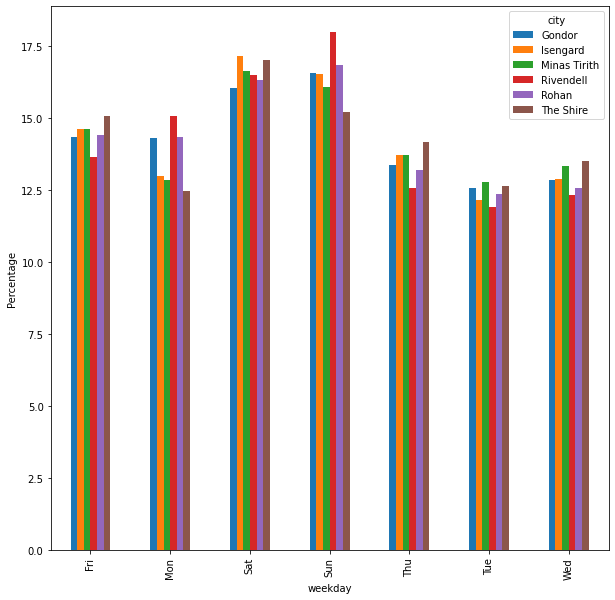

In [29]:
# plot grouped bar chart 
df_pivot = pd.pivot_table(
	df,
	values="Percentage",
	index="weekday",
	columns="city",
)

ax = df_pivot.plot(kind="bar")
ax.set_ylabel("Percentage")
fig = ax.get_figure()
fig.set_size_inches(10, 10)
print('Conclusion: In all cities, Sundays and Saturdays tend to have more travel than other weekdays ')
plt.show()

## Part3. RDDs vs DataFrame vs Spark SQL <a class="anchor" id="task3"></a>

In [30]:
from time import time
# Query: Join the trip and city csv based on 'city_id', only keep all the data in 'Minas Tirith' city,
# show id of trip, city name, and call time in the output.

# RDD:
#start counting 
t0_rdd = time()
#read data
trip_rdd = sc.textFile('data//trip.csv')
city_rdd = sc.textFile('data//city.csv')
#Remove header and expand string
trip_rdd_header = trip_rdd.first()
city_rdd_header = city_rdd.first()
trip_rdd = trip_rdd.filter(lambda x : x != trip_rdd_header).map(lambda x : x.split(','))
city_rdd = city_rdd.filter(lambda x : x != city_rdd_header).map(lambda x : x.split(','))
#format rdd to key value pair
trip_rdd = trip_rdd.map(lambda x : (x[3], [x[0] ,x[4]]))
city_rdd = city_rdd.map(lambda x : (x[0], [x[1]]))
#Join the trip and city csv based on 'city_id'
# print(trip_rdd.take(5))
# print(city_rdd.take(5))
rdd_join = trip_rdd.join(city_rdd)
#show id of trip, city name, and call time in the output
filter_rdd_join = rdd_join.map(lambda x:x[1]).filter(lambda x:x[1][0] == 'Minas Tirith')
tt_rdd = time() - t0_rdd
print('show id of trip, call time and city name in the output')
print(*filter_rdd_join.take(5),sep='\n')
print ("RDD query performed in " , tt_rdd , " seconds")

show id of trip, call time and city name in the output
(['a84c0db2', '9/8/2019 10:01:28 PM'], ['Minas Tirith'])
(['a84c2d10', '7/1/2019 8:56:28 PM'], ['Minas Tirith'])
(['a84c5ce2', '6/10/2019 9:29:18 AM'], ['Minas Tirith'])
(['a84ceb22', '6/30/2019 3:09:18 AM'], ['Minas Tirith'])
(['a84d29a0', '8/11/2019 9:49:49 PM'], ['Minas Tirith'])
RDD query performed in  0.14787817001342773  seconds


In [31]:
#Dataframe:
#start counting 
t0_Dataframe = time()
#read data
trip_Dataframe = spark.read.csv("data//trip.csv",header=True,inferSchema=True)
city_Dataframe = spark.read.csv("data//city.csv",header=True,inferSchema=True)
#join data on city_id, show id of trip, city name, and call time in the output
join_Dataframe = trip_Dataframe.join(city_Dataframe, trip_Dataframe.city_id == city_Dataframe.id ,how='inner').\
    select(trip_Dataframe.id , city_Dataframe.name ,trip_Dataframe.call_time).filter(city_Dataframe.name == 'Minas Tirith')
tt_Dataframe = time() - t0_Dataframe
print ("Dataframe query performed in " ,tt_Dataframe ," seconds")
join_Dataframe.show(5)

Dataframe query performed in  1.7288658618927002  seconds
+--------+------------+--------------------+
|      id|        name|           call_time|
+--------+------------+--------------------+
|a84c0db2|Minas Tirith|9/8/2019 10:01:28 PM|
|a84c2d10|Minas Tirith| 7/1/2019 8:56:28 PM|
|a84c5ce2|Minas Tirith|6/10/2019 9:29:18 AM|
|a84ceb22|Minas Tirith|6/30/2019 3:09:18 AM|
|a84d29a0|Minas Tirith|8/11/2019 9:49:49 PM|
+--------+------------+--------------------+
only showing top 5 rows



In [32]:
#Spark SQL:
t0_sql = time()
#read data
trip_sql = spark.read.csv("data//trip.csv",header=True)
city_sql = spark.read.csv("data//city.csv",header=True)
trip_sql.createOrReplaceTempView("trip_sql")
city_sql.createOrReplaceTempView("city_sql")
df_sql = spark.sql('''
  SELECT 
      trip_sql.id,
      city_sql.name,
      trip_sql.call_time
  FROM trip_sql
  JOIN city_sql ON trip_sql.city_id = city_sql.id
  WHERE city_sql.name = 'Minas Tirith';
''')
tt_sql = time() - t0_sql
print ("Dataframe query performed in " , tt_sql , " seconds")
df_sql.take(5)

Dataframe query performed in  0.48000192642211914  seconds


[Row(id='a84c0db2', name='Minas Tirith', call_time='9/8/2019 10:01:28 PM'),
 Row(id='a84c2d10', name='Minas Tirith', call_time='7/1/2019 8:56:28 PM'),
 Row(id='a84c5ce2', name='Minas Tirith', call_time='6/10/2019 9:29:18 AM'),
 Row(id='a84ceb22', name='Minas Tirith', call_time='6/30/2019 3:09:18 AM'),
 Row(id='a84d29a0', name='Minas Tirith', call_time='8/11/2019 9:49:49 PM')]

In [33]:
print(f'Query time taken, SparkSQL: {tt_sql}, Spark dataframe:{tt_Dataframe}, Spark RDD {tt_rdd}')

Query time taken, SparkSQL: 0.48000192642211914, Spark dataframe:1.7288658618927002, Spark RDD 0.14787817001342773


Speak of running speed, Spark RDD is fastest, Spark dataframe is slowest and it is much slower than other two options

But RDD need to define the dataset or schema by myself, dataframe and SQL can be done by the in-built functions and both of them are easy 

to write with a faster aggregation and groupby

In [34]:
%%time
filter_rdd_join.groupByKey()

CPU times: user 10.2 ms, sys: 3.78 ms, total: 14 ms
Wall time: 36.5 ms


PythonRDD[238] at RDD at PythonRDD.scala:53

In [35]:
%%time
join_Dataframe.groupBy('name')

CPU times: user 1.62 ms, sys: 1.1 ms, total: 2.72 ms
Wall time: 10.2 ms
